# Определение стоимости автомобилей

<b>Описание проекта</b>  

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля.  
В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам надо построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.  

Наша задача:    
- Загрузить и изучить данные.  
- Заполнить пропущенные значения и обработайть аномалии в столбцах. Если среди признаков имеются неинформативные, удалить их.  
- Подготовьть выборки для обучения моделей.  
- Обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробовать разные гиперпараметры.  
- Проанализировать время обучения, время предсказания и качество моделей.  
- Опираясь на критерии заказчика, выбрать лучшую модель, проверить её качество на тестовой выборке.  

Признаки:
    
    DateCrawled — дата скачивания анкеты из базы
    VehicleType — тип автомобильного кузова
    RegistrationYear — год регистрации автомобиля
    Gearbox — тип коробки передач
    Power — мощность (л. с.)
    Model — модель автомобиля
    Kilometer — пробег (км)
    RegistrationMonth — месяц регистрации автомобиля
    FuelType — тип топлива
    Brand — марка автомобиля
    Repaired — была машина в ремонте или нет
    DateCreated — дата создания анкеты
    NumberOfPictures — количество фотографий автомобиля
    PostalCode — почтовый индекс владельца анкеты (пользователя)
    LastSeen — дата последней активности пользователя

Целевой признак
Price — цена (евро)

Примечания:

    Для оценки качества моделей применяйте метрику RMSE.
    Значение метрики RMSE должно быть меньше 2500.




## Изучение файла с данными

In [248]:
!pip3 install catboost
!pip install lightgbm

In [249]:
# Импортируем библиотеки
import warnings

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import (RandomizedSearchCV,
                                     train_test_split)
from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder,
                                   StandardScaler)
from tqdm import trange
import time

warnings.filterwarnings("ignore")

In [250]:
# Определим константы
RANDOM_STATE = 42
PERC = np.arange(0,1,0.05)

In [251]:
# Читаем данные из csv-файла и сохраним в переменную
data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [252]:
# Изучим общую информацию о полученном датафрейме
display(data.info(), data.head(), 
        data.describe(include='all').round(2).T,
        data.corr().style.background_gradient(cmap='YlGn'),
        data.isna().sum(), data.shape)                                    
print('Количество дупликатов:', data.duplicated().sum()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
DateCrawled,354369,271174,2016-03-24 14:49:47,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,354369.0,NaN,NaN,NaN,4416.66,4514.16,0.0,1050.0,2700.0,6400.0,20000.0
VehicleType,316879,8,sedan,91457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RegistrationYear,354369.0,NaN,NaN,NaN,2004.23,90.23,1000.0,1999.0,2003.0,2008.0,9999.0
Gearbox,334536,2,manual,268251,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Power,354369.0,NaN,NaN,NaN,110.09,189.85,0.0,69.0,105.0,143.0,20000.0
Model,334664,250,golf,29232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kilometer,354369.0,NaN,NaN,NaN,128211.17,37905.34,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,NaN,NaN,NaN,5.71,3.73,0.0,3.0,6.0,9.0,12.0
FuelType,321474,7,petrol,216352,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,nan,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,nan,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,nan,0.021665
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,nan,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,nan,0.013995
NumberOfPictures,nan,nan,nan,nan,nan,nan,nan
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,nan,1.000000


DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

(354369, 16)

Количество дупликатов: 4


В таблице 16 столбцов и 354369 строк.  
В столбцах 'VehicleType', 'Model', 'Gearbox', 'FuelType', 'Repaired' есть пропуски.    
Имеются аномальные значения в столбцах:  
'Price' - в столбце с ценами присутствуют нули,  
'RegistrationYear' - минимальный год регистриции автомобиля 1000, максимальный - 9999,  
'Power' - максимальная мощность автомобиля в лошадинных силах равна 20 000 и минимальная  равна 0,   
'NumberOfPictures' - не заполнен,  
'Kilometer' - часто повторяется максимальный пробег - 150000, возможно простое ограничение ввода данных на сайте.  
'Price' прямо пропорционально зависит от 'RegistrationYear' и 'Power', и обратно пропорционально зависит от 'Kilometer'. Также 'RegistrationYear' обратно пропорционально зависит от 'Kilometer'.    
Присутствуют явные дупликаты.

## Предобработка данных

### Удаление дупликатов

In [253]:
data.drop_duplicates(inplace=True)  
print('Количество дупликатов:', data.duplicated().sum()) 

Количество дупликатов: 0


### Удаление столбцов

Столбцы 'DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen' - являются неинформативными для последующего обучения моделей, поэтому мы их удалим. 

In [254]:
data.drop(columns=['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'],
          inplace=True,
          errors='ignore')

### Работа с названиями столбцов

In [255]:
# Переименуем столбцы в соответствии с рекомендациями PEP 8
data.columns = data.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
data.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

### Работа с типами данных

In [256]:
# Приведем столбцы с типом 'int64' к типу данных 'int32'
int64_cols = list(data.select_dtypes(include='int64'))

data[int64_cols] = data[int64_cols].astype('int32')

### Работа с пропущенными значениями в столбцах

Проверим уникальные значения для всех столбцов с пропусками.

In [257]:
# Проверим уникальные значения
data['vehicle_type'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [258]:
# Заменим пропуски на unknown
data['vehicle_type'] = data['vehicle_type'].fillna('unknow')

In [259]:
# Проверим уникальные значения
data['model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [260]:
# Заменим пропуски на unknown
data['model'] = data['model'].fillna('unknow')

In [261]:
# Проверим уникальные значения
data['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [262]:
# Заменим пропуски на unknown
data['gearbox'] = data['gearbox'].fillna('unknow')

In [263]:
# Проверим уникальные значения
data['fuel_type'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [264]:
# Заменим пропуски на unknown
data['fuel_type'] = data['fuel_type'].fillna('unknow')

In [265]:
# Проверим уникальные значения
data['repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

In [266]:
# Заменим пропуски на unknown
data['repaired'] = data['repaired'].fillna('unknow')

In [267]:
# Проверим количество пропущенных значений для каждого столбца повторно
data.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

В данных столбцах самостоятельно заполнить пропуски мы не можем, заполнили пропуски во всех столбцах значениями-заглушками.

### Работа с редкими и выбивающимися значениями 

#### Столбец 'price'

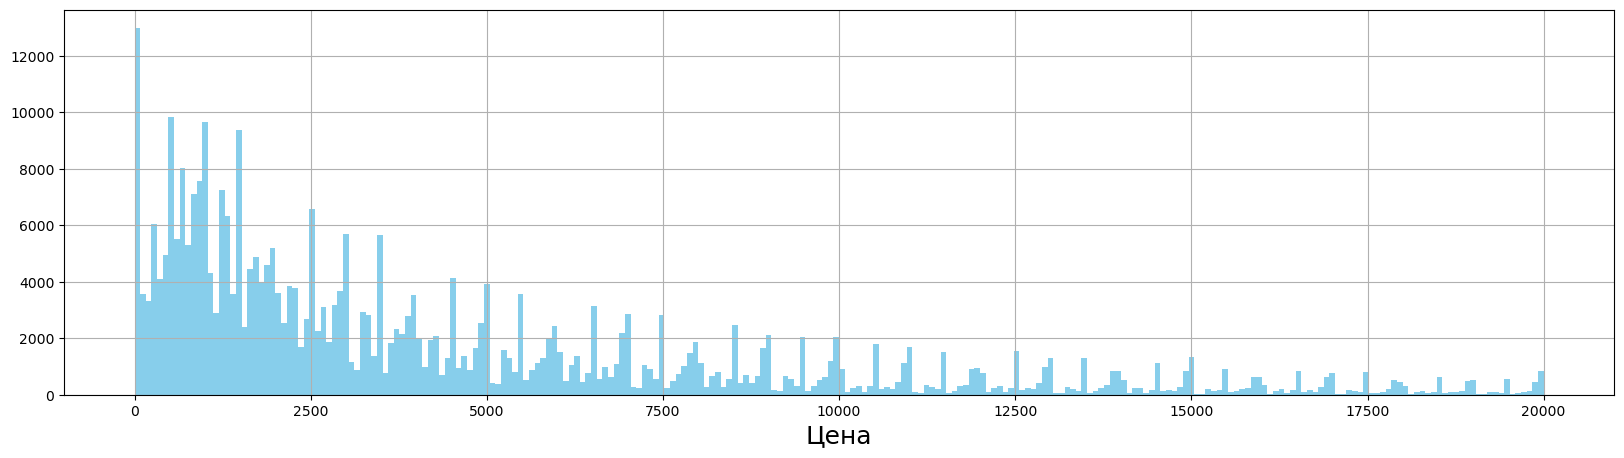

In [268]:
# Построим гистограмму для столбца 'price'
data.price.hist(bins=250, figsize=(20,5), color='skyblue').set_xlabel('Цена', fontsize=18);

По графику видно, что количество объявлений с ценой равной нулю достаточно много. Пользователи не стали заполнять стоимость автомобиля. Заполнить цену сами мы не можем. 

In [269]:
# Количество объялений с ценой равной нулю
len(data[['price']][(data['price'] == 0)])

10772

In [270]:
print(data['price'].describe(percentiles = PERC))

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
0%            0.000000
5%          200.000000
10%         499.000000
15%         650.000000
20%         880.000000
25%        1050.000000
30%        1300.000000
35%        1599.000000
40%        1900.000000
45%        2300.000000
50%        2700.000000
55%        3200.000000
60%        3800.000000
65%        4500.000000
70%        5350.000000
75%        6400.000000
80%        7500.000000
85%        9000.000000
90%       11450.000000
95%       14600.000000
max       20000.000000
Name: price, dtype: float64


Можно установить минимальную стоимость автомобиля, она может равняться 5 персентилю. Максимальную стоимость авто ограничивать не будем.

In [271]:
# Проверим количество строк с ценой ниже 200 евро
len(data[['price']][(data['price'] < 200)])

17462

In [272]:
# Удалим из датасета строки с ценой ниже 200 евро
data.drop(data[data['price'] < 200].index, inplace=True)

#### Столбец 'registration_year'

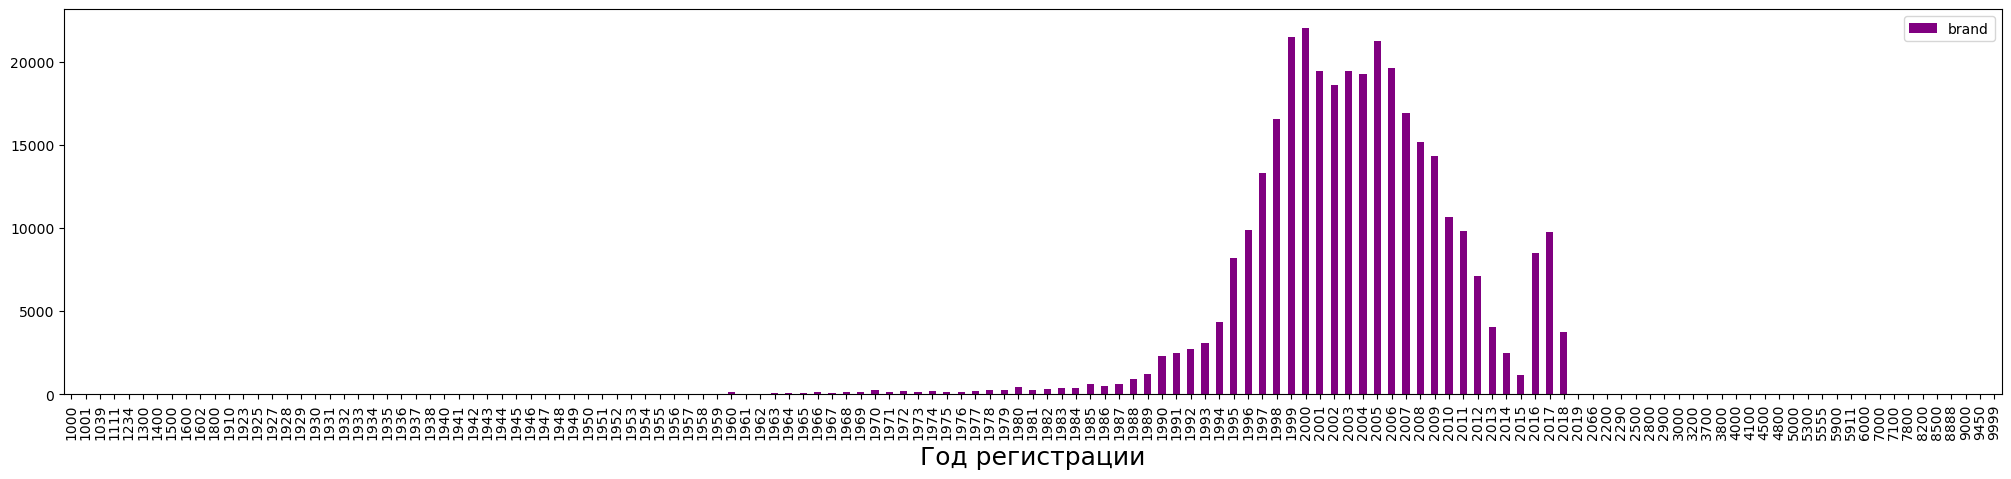

In [273]:
# Построим график для столбца 'registration_year'
data.pivot_table(index='registration_year', values='brand', aggfunc='count').\
plot.bar(figsize = (25,5), color='purple').set_xlabel('Год регистрации', fontsize=18);

In [274]:
#data.groupby('registration_year')['brand'].count().\
#plot(kind='bar',figsize=(25,5), color='purple').set_xlabel('Год регистрации', fontsize=18);

Объявления с машинами, выпущенными раннее 1987 года и позднее 2016 года - максимальный год размещения в базе объявлений, можно удалить. 

In [275]:
data.drop(data[data['registration_year'] < 1987].index, inplace=True)
data.drop(data[data['registration_year'] > 2016].index, inplace=True)

#### Столбец 'power'

In [276]:
print(data['power'].describe(percentiles = PERC))

count    317356.000000
mean        113.673216
std         184.009173
min           0.000000
0%            0.000000
5%            0.000000
10%          45.000000
15%          58.000000
20%          63.000000
25%          75.000000
30%          75.000000
35%          87.000000
40%          95.000000
45%         101.000000
50%         105.000000
55%         115.000000
60%         120.000000
65%         129.000000
70%         140.000000
75%         143.000000
80%         150.000000
85%         170.000000
90%         184.000000
95%         218.000000
max       20000.000000
Name: power, dtype: float64


В столбце мощности также есть большое количество нулей и выбивающихся значений. Удалим из столбца 'power' объявления с мощностью ниже 45 лс и выше 250 лс.

In [277]:
data.drop(data[data['power'] < 45].index, inplace=True)
data.drop(data[data['power'] > 250].index, inplace=True)

In [278]:
# Проверим общую информацию о нашем датафрейме
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279946 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              279946 non-null  int32 
 1   vehicle_type       279946 non-null  object
 2   registration_year  279946 non-null  int32 
 3   gearbox            279946 non-null  object
 4   power              279946 non-null  int32 
 5   model              279946 non-null  object
 6   kilometer          279946 non-null  int32 
 7   fuel_type          279946 non-null  object
 8   brand              279946 non-null  object
 9   repaired           279946 non-null  object
dtypes: int32(4), object(6)
memory usage: 19.2+ MB


В ходе предобработки данных в таблице осталось 10 столбцов и 279946 строк. Мы переименовали столбцы в соответствии с рекомендациями PEP 8. Также заменили пропуски в столбцах 'vehicle_type', 'model', 'gearbox', 'fuel_type', 'repaired' на значения-заглушки 'unknown', т.к. самостоятельно заполнить пропущенные данные мы не можем. В столбцах 'price', 'registration_year', 'power' мы проверили редкие и выбивающиеся значения и поддкорректировали данные. Столбцы 'DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen' - являются неинформативными для последующего обучения моделей, поэтому мы их удалили. 

## Обучение моделей

In [279]:
# Разобьем данные data на признаки и целевой признак, сохраним в отдельных переменных
features = data.drop('price', axis=1).copy()
target = data.price.copy()

In [280]:
# Разобьем данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE) 

In [281]:
# Выведем на экран размеры этих выборок
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(209959, 9)
(209959,)
(69987, 9)
(69987,)


In [282]:
# Категориальные признаки для OHE кодирония 
ohe_features = X_train.select_dtypes(include='object').columns.to_list()
ohe_features.remove('model')
ohe_features

['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'repaired']

In [283]:
# Категориальные признаки для OE кодирония 
oe_features = ['model']
oe_features

['model']

In [284]:
# Категориальные признаки 
cat_features = X_train.select_dtypes(include='object').columns.to_list()
cat_features

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

In [285]:
# Численные признаки
num_features = X_train.select_dtypes(exclude='object').columns.to_list()
num_features

['registration_year', 'power', 'kilometer']

In [286]:
# Пайплайн для OHE кодирония
ohe_pipe = Pipeline([('ohe', OneHotEncoder(sparse=False, 
                      handle_unknown='ignore'))])

In [287]:
# Пайплайн для численных признаков
num_pipe = Pipeline([('scaler', StandardScaler())])

In [288]:
# Пайплайн для OE кодирония
oe_pipe = Pipeline([('oe_rf', OrdinalEncoder(categories = [['5er', 'laguna', 'golf', 'a3', '100', 'fabia', 'unknow',
       'e_klasse', 'polo', '3er', 'clio', 'touran', 'passat', 'roomster',
       'mondeo', 'c4', 'corsa', 'focus', 'auris', 'c_klasse', 'sharan',
       '80', 'a4', 's_max', '1er', 'twingo', '500', 'other', 'sprinter',
       'a6', 'i_reihe', 'cordoba', 'astra', 'cuore', 'leon', 'a_klasse',
       'grand', 'ka', 'insignia', 's_type', 'picanto', 'avensis',
       'transporter', 'calibra', '2_reihe', 'punto', 'arosa', 'fortwo',
       'omega', 'clk', '3_reihe', 'octavia', '6_reihe', 'fiesta',
       'qashqai', 'scenic', 'espace', 'lancer', 'scirocco', 'lupo',
       'zafira', 'meriva', 'up', 'bora', 'exeo', 'megane', 'ibiza',
       'corolla', '156', 'viano', 'delta', 'matiz', 'z_reihe', 'caddy',
       'beetle', 'jazz', 'forfour', 'seicento', 'tt', 'yaris', '4_reihe',
       'x_reihe', 'v50', 'transit', 'cooper', 'eos', 'c3', 'sandero',
       'r19', 'm_klasse', 'civic', 'c_max', 'primera', 'mustang',
       'vectra', 'x_trail', 'verso', 'micra', 'v40', 'berlingo', 'navara',
       'rio', 'carnival', 'agila', 'getz', '5_reihe', 'impreza', 'vito',
       'a5', 'roadster', 'v70', 'touareg', 'panda', 'aygo', 'vivaro',
       'rx_reihe', 'stilo', 'kuga', 'c5', 'sirion', 'almera', 'fusion',
       'bravo', 'captiva', 'galaxy', 'aveo', 'antara', 'b_klasse',
       'tiguan', '1_reihe', 'cr_reihe', 'boxster', 'colt', 'jetta', 'slk',
       'santa', 'accord', 'swift', 'superb', 'sl', 'lodgy', '159', '850',
       'rav', 'c_reihe', 'modus', 'carisma', 'freelander', 'tucson',
       'niva', 'clubman', 'duster', 'v_klasse', 'kangoo', 'note', 'a1',
       'one', 'xc_reihe', 'jimny', '7er', 'tigra', 'pajero', 'a2', '147',
       'move', 'cc', 'voyager', 'sportage', 'ypsilon', 'toledo',
       'range_rover', 'cherokee', 'crossfire', 'mx_reihe', 'q5', 'c2',
       'b_max', 'doblo', 'legacy', 'spark', 's_klasse', 'escort',
       'signum', 'musa', 'juke', 'fox', 'x_type', 'justy', 'cx_reihe',
       'ceed', 'c1', 'forester', 'sorento', 'alhambra', 'combo', 'galant',
       'kappa', 'ptcruiser', 'defender', 'kadett', 'cayenne', 'ducato',
       'logan', 'outlander', 'g_klasse', '900', 'altea', 'discovery',
       'a8', 'q7', 'phaeton', 'lanos', 'yeti', 'wrangler', 'q3', '200',
       'terios', 'citigo', '145', 'lybra', 'spider', 's60', 'nubira',
       '90', 'charade', 'glk', 'cl', 'kaefer', 'm_reihe', 'amarok',
       'croma', 'mii', 'kalos', 'range_rover_sport', '300c', 'gl', '9000',
       'v60', '911', 'materia', 'samara', 'kalina', '6er', 'elefantino',
       'i3', 'rangerover']]))])

Для обучения моделей применим следующие библиотеки: RandomForestRegressor, CatboostRegressor и LightGBMRegressor.  
Для RandomForestRegressor и LightGBMRegressor будем использовать порядковое кодирование признака 'model', имеющего большое количество уникальных значений, и OHE кодирование остальных категориальных признаков.    
Для CatBoostRegressor укажем все категориальные признаки.

### RandomForestRegressor

In [289]:
# Поместим пайплайны в ColumnTransformer
preprocessor_rf = ColumnTransformer(transformers=[('cat_ohe', ohe_pipe, ohe_features),
                                               ('num', num_pipe, num_features), 
                                               ('cat_oe', oe_pipe, oe_features)],
                                                remainder='passthrough') 

In [290]:
%%time
start = time.time()

model_rf = RandomForestRegressor(random_state=RANDOM_STATE)

# Создадим пайплайн
pipeline_rf = Pipeline([('preprocessor_rf', preprocessor_rf),
                       ('randomforestregressor', model_rf)])

# Cловарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_rf = {'randomforestregressor__n_estimators': range(2, 31, 2),
                 'randomforestregressor__max_depth': range(2, 15),
                 'randomforestregressor__min_samples_split': (2, 3, 4),
                 'randomforestregressor__min_samples_leaf': (1, 2, 3, 4)}

# Будем использовать RandomizedSearchCV при переборе комбинаций гиперпараметров
random_cv_rf = RandomizedSearchCV(estimator=pipeline_rf, 
                           param_distributions=param_grid_rf, 
                           scoring='neg_root_mean_squared_error',
                           cv=5,
                           n_iter=10,
                           n_jobs=-1, 
                           random_state=RANDOM_STATE,
                           verbose=10)

random_cv_rf.fit(X_train, y_train)
end = time.time()
t_rf = round(end-start,2)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: total: 28.2 s
Wall time: 3min 21s


In [291]:
random_cv_rf_best_score = random_cv_rf.best_score_ 
random_cv_rf_best_params = random_cv_rf.best_params_

# Лучшее значение RMSE 
print(f'best_score: {round(-random_cv_rf_best_score,3)}')
# Лучшие гиперпараметры
print(f'best_params: {random_cv_rf_best_params}')

best_score: 1555.808
best_params: {'randomforestregressor__n_estimators': 20, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__max_depth': 14}


In [292]:
# Инициируем модель с лучшими параметрами
model_rf_best = RandomForestRegressor(max_depth=14,
                                      min_samples_leaf=1,
                                      min_samples_split=2,
                                      n_estimators=20,
                                      random_state=42)
# Создадим пайплайн для лучшей модели
pipline_rf_best = Pipeline([('preprocessor_rf', preprocessor_rf),
                            ('randomforestregressor', model_rf_best)])

pipline_rf_best.fit(X_train, y_train)

Pipeline(steps=[('preprocessor_rf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'fuel_type', 'brand',
                                                   'repaired']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['registration_year', 'power',
                                                   'kilometer']),
                                                 ('cat_oe',
                                                  Pipel...
                                                                   OrdinalEncoder(categories=[['5er',
                                                                                               'laguna',
                                                                                               'golf',
                                                                                               'a3',
                                                                                               '100',
                                                                                               'fabia',
                                                                                               'unknow',
                                                                                               'e_klasse',
                                                                                               'polo',
                                                                                               '3er',
                                                                                               'clio',
                                                                                               'touran',
                                                                                               'passat',
                                                                                               'roomster',
                                                                                               'mondeo',
                                                                                               'c4',
                                                                                               'corsa',
                                                                                               'focus',
                                                                                               'auris',
                                                                                               'c_klasse',
                                                                                               'sharan',
                                                                                               '80',
                                                                                               'a4',
                                                                                               's_max',
                                                                                               '1er',
                                                                                               'twingo',
                                                                                               '500',
                                                             

In [293]:
%%time
start = time.time()
# Замерим время предсказания лучшей модели на тренировочной выборке
predict_rf_best = pipline_rf_best.predict(X_train)
end = time.time()
t_rf_pr = round(end-start,2)

CPU times: total: 1 s
Wall time: 981 ms


In [294]:
# Занесем результаты в таблицу
result_rf = pd.DataFrame([round(-random_cv_rf_best_score,3), t_rf, t_rf_pr], 
                         index=['RMSE', 'Fit Time', 'Predict Time'], 
                         columns=['RandomForestRegressor'])
result_rf      

,RandomForestRegressor
RMSE,1555.808
Fit Time,201.230
Predict Time,0.980


### LightGBMRegressor

In [295]:
# Поместим пайплайны в ColumnTransformer
preprocessor_lgbm = ColumnTransformer(transformers=[('cat_ohe', ohe_pipe, ohe_features),
                                               ('num', num_pipe, num_features), 
                                               ('cat_oe', oe_pipe, oe_features)],
                                                remainder='passthrough') 

In [296]:
%%time
start = time.time()

model_lgbm = LGBMRegressor(objective='regression',
                           boosting_type='gbdt',
                           random_state=RANDOM_STATE)
# Создадим пайплайн                        
pipeline_lgbm = Pipeline([('preprocessor_lgbm', preprocessor_lgbm),
                          ('lightgbmregressor', model_lgbm)])

# Cловарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_lgbm = {'lightgbmregressor__n_estimators': range(2, 31, 2),
                   'lightgbmregressor__max_depth': range(2, 15),
                   'lightgbmregressor__num_leaves': [25, 50, 100, 200],
                   'lightgbmregressor__learning_rate': [.1, .3, .5]}

# Будем использовать RandomizedSearchCV при переборе комбинаций гиперпараметров
random_cv_lgbm = RandomizedSearchCV(estimator=pipeline_lgbm, 
                                    param_distributions=param_grid_lgbm, 
                                    scoring='neg_root_mean_squared_error',
                                    cv=5,
                                    n_iter=10,
                                    n_jobs=-1, 
                                    random_state=RANDOM_STATE,
                                    verbose=10)

random_cv_lgbm.fit(X_train, y_train)
end = time.time()
t_lgbm = round(end-start,2)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 617
[LightGBM] [Info] Number of data points in the train set: 209959, number of used features: 66
[LightGBM] [Info] Start training from score 4754.300692
CPU times: total: 6.03 s
Wall time: 26.1 s


In [297]:
random_cv_lgbm_best_score = random_cv_lgbm.best_score_
random_cv_lgbm_best_params = random_cv_lgbm.best_params_

# лучшее значение RMSE 
print(f'best_score: {round(-random_cv_lgbm_best_score,3)}')
# лучшие гиперпараметры
print(f'best_params: {random_cv_lgbm_best_params}')

best_score: 1516.461
best_params: {'lightgbmregressor__num_leaves': 100, 'lightgbmregressor__n_estimators': 22, 'lightgbmregressor__max_depth': 13, 'lightgbmregressor__learning_rate': 0.3}


In [298]:
# Инициируем модель с лучшими параметрами
model_lgbm_best = LGBMRegressor(learning_rate=0.3,
                                max_depth=13,
                                n_estimators=22,
                                num_leaves=100,
                                objective='regression',
                                random_state=42)
pipline_lgbm_best = Pipeline([('preprocessor_lgbm', preprocessor_lgbm),
                            ('lightgbmregressor', model_lgbm_best)])
pipline_lgbm_best.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 617
[LightGBM] [Info] Number of data points in the train set: 209959, number of used features: 66
[LightGBM] [Info] Start training from score 4754.300692


Pipeline(steps=[('preprocessor_lgbm',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'fuel_type', 'brand',
                                                   'repaired']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['registration_year', 'power',
                                                   'kilometer']),
                                                 ('cat_oe',
                                                  Pip...
                                                                                               'unknow',
                                                                                               'e_klasse',
                                                                                               'polo',
                                                                                               '3er',
                                                                                               'clio',
                                                                                               'touran',
                                                                                               'passat',
                                                                                               'roomster',
                                                                                               'mondeo',
                                                                                               'c4',
                                                                                               'corsa',
                                                                                               'focus',
                                                                                               'auris',
                                                                                               'c_klasse',
                                                                                               'sharan',
                                                                                               '80',
                                                                                               'a4',
                                                                                               's_max',
                                                                                               '1er',
                                                                                               'twingo',
                                                                                               '500',
                                                                                               'other',
                                                                                               'sprinter',
                                                                                               'a6', ...]]))]),
                                                  ['model'])])),
                ('lightgbmregressor',
                 LGBMRegressor(learning_rate=0.3, max_depth=13, n_estimators=22,
                               num_leaves=100, objective='regression',
                               random_state=42))])

In [299]:
%%time
start = time.time()
# Замерим время предсказания лучшей модели на тренировочной выборке
predict_lgbm_best = pipline_lgbm_best.predict(X_train)
end = time.time()
t_lgbm_pr = round(end-start,2)

CPU times: total: 1.05 s
Wall time: 408 ms


In [300]:
# Занесем результаты в таблицу
result_lgbm = pd.DataFrame([round(-random_cv_lgbm_best_score,3), t_lgbm, t_lgbm_pr], 
                         index=['RMSE', 'Fit Time', 'Predict Time'], 
                         columns=['LGBMRegressor'])
result_lgbm        

,LGBMRegressor
RMSE,1516.461
Fit Time,26.140
Predict Time,0.410


### CatBoostRegressor

In [301]:
# Поместим пайплайны в ColumnTransformer
preprocessor_cbr = ColumnTransformer(transformers=[('cat_ohe', ohe_pipe, cat_features),
                                                   ('num', num_pipe, num_features)],
                                                     remainder='passthrough') 

In [302]:
%%time
start = time.time()

model_cbr = CatBoostRegressor(random_state=RANDOM_STATE)          
                              
# Создадим пайплайн 
pipeline_cbr = Pipeline([('preprocessor_cbr', preprocessor_cbr),
                        ('catboostregressor', model_cbr)])

# Cловарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_cbr = {'catboostregressor__n_estimators': range(2, 100, 2),
                  'catboostregressor__max_depth': range(2, 15),
                  'catboostregressor__learning_rate': [.1, .3, .5]}


# Будем использовать RandomizedSearchCV при переборе комбинаций гиперпараметров
random_cv_cbr = RandomizedSearchCV(estimator=pipeline_cbr, 
                                   param_distributions=param_grid_cbr, 
                                   scoring='neg_root_mean_squared_error',
                                   cv=5,
                                   n_iter=10,
                                   n_jobs=-1, 
                                   random_state=RANDOM_STATE,
                                   verbose=30)

random_cv_cbr.fit(X_train, y_train)
end = time.time()
t_cbr = round(end-start,2)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 3504.2798427	total: 41.9ms	remaining: 4.07s
1:	learn: 2850.5158605	total: 84.1ms	remaining: 4.03s
2:	learn: 2432.2346861	total: 126ms	remaining: 4s
3:	learn: 2155.0394933	total: 166ms	remaining: 3.9s
4:	learn: 1985.2430337	total: 208ms	remaining: 3.87s
5:	learn: 1866.3349268	total: 254ms	remaining: 3.89s
6:	learn: 1796.1055261	total: 296ms	remaining: 3.85s
7:	learn: 1744.4783221	total: 337ms	remaining: 3.79s
8:	learn: 1713.9157532	total: 379ms	remaining: 3.75s
9:	learn: 1684.8434653	total: 420ms	remaining: 3.7s
10:	learn: 1664.1754411	total: 464ms	remaining: 3.67s
11:	learn: 1650.0411789	total: 504ms	remaining: 3.61s
12:	learn: 1634.9260098	total: 546ms	remaining: 3.57s
13:	learn: 1622.7767840	total: 587ms	remaining: 3.52s
14:	learn: 1612.9903260	total: 628ms	remaining: 3.48s
15:	learn: 1605.6906953	total: 670ms	remaining: 3.43s
16:	learn: 1594.9511482	total: 714ms	remaining: 3.4s
17:	learn: 1587.5931461	total: 755m

In [303]:
random_cv_cbr_best_score = random_cv_cbr.best_score_
random_cv_cbr_best_params = random_cv_cbr.best_params_

# лучшее значение RMSE 
print(f'best_score: {round(-random_cv_cbr_best_score,3)}')
# лучшие гиперпараметры
print(f'best_params: {random_cv_cbr_best_params}')

best_score: 1453.698
best_params: {'catboostregressor__n_estimators': 98, 'catboostregressor__max_depth': 11, 'catboostregressor__learning_rate': 0.3}


In [304]:
# Инициируем модель с лучшими параметрами
model_cbr_best = CatBoostRegressor(max_depth=11,
                                learning_rate=0.3,
                                n_estimators=98,
                                random_state=42,
                                verbose=30)
                                
pipline_cbr_best = Pipeline([('preprocessor_cbr', preprocessor_cbr),
                            ('catboostregressor', model_cbr_best)])
pipline_cbr_best.fit(X_train, y_train)

0:	learn: 3504.2798427	total: 41.7ms	remaining: 4.05s
30:	learn: 1519.2826773	total: 1.27s	remaining: 2.74s
60:	learn: 1438.7223899	total: 2.49s	remaining: 1.51s
90:	learn: 1390.5430906	total: 3.71s	remaining: 285ms
97:	learn: 1381.2491073	total: 4s	remaining: 0us


Pipeline(steps=[('preprocessor_cbr',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'repaired']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['registration_year', 'power',
                                                   'kilometer'])])),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x000001B89BCF35B0>)])

In [305]:
%%time
start = time.time()
# Замерим время предсказания лучшей модели на тренировочной выборке
predict_cbr_best = pipline_cbr_best.predict(X_train)
end = time.time()
t_cbr_pr = round(end-start,2)

CPU times: total: 17.2 s
Wall time: 16.6 s


In [306]:
# Занесем результаты в таблицу
result_cbr = pd.DataFrame([round(-random_cv_cbr_best_score,3), t_cbr, t_cbr_pr], 
                         index=['RMSE', 'Fit Time', 'Predict Time'], 
                         columns=['CatBoostRegressor'])
result_cbr        

,CatBoostRegressor
RMSE,1453.698
Fit Time,253.740
Predict Time,16.630


## Анализ моделей

Для обучения моделей мы применили следующие библиотеки: RandomForestRegressor, CatboostRegressor и LightGBMRegressor. Для каждой модели мы подбирали оптимальные гиперпараметры с целью получения минимальной оценки метрики RMSE. Также мы измеряли время обучения и время предсказания моделей.

In [307]:
# Объеденим данные в одну таблицу
result = pd.concat([result_rf, result_lgbm, result_cbr], axis=1)
result

,RandomForestRegressor,LGBMRegressor,CatBoostRegressor
RMSE,1555.808,1516.461,1453.698
Fit Time,201.230,26.140,253.740
Predict Time,0.980,0.410,16.630


Наилучшей моделью стала CatBoostRegressor с минимальным показалем RMSE 1453.698 на тренировочной выборке, а также минимальным временем обучения и предсказания.   

## Тестирование лучшей модели

Проверим результаты выбранной модели на тестовой выборке.

In [308]:
# Численные признаки
num_features_test = X_test.select_dtypes(exclude='object').columns.to_list()
num_features_test

['registration_year', 'power', 'kilometer']

In [309]:
# Категориальные признаки 
cat_features_test = X_test.select_dtypes(include='object').columns.to_list()
cat_features_test

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

In [310]:
# Поместим пайплайны в ColumnTransformer
preprocessor_cbr_test = ColumnTransformer(transformers=[('cat_ohe', ohe_pipe, cat_features_test),
                                               ('num', num_pipe, num_features_test)],
                                                remainder='passthrough') 


In [311]:
# Инициируем модель с лучшими параметрами
model_cbr_best = CatBoostRegressor(max_depth=11,
                                learning_rate=0.3,
                                n_estimators=98,
                                random_state=42,
                                verbose=30)
                                
pipline_cbr_best = Pipeline([('preprocessor_cbr_test', preprocessor_cbr_test),
                            ('catboostregressor', model_cbr_best)])
pipline_cbr_best.fit(X_test, y_test)

0:	learn: 3531.3175204	total: 33ms	remaining: 3.2s
30:	learn: 1523.1605313	total: 966ms	remaining: 2.09s
60:	learn: 1434.9292356	total: 1.89s	remaining: 1.15s
90:	learn: 1368.7827800	total: 2.83s	remaining: 217ms
97:	learn: 1357.2781914	total: 3.05s	remaining: 0us


Pipeline(steps=[('preprocessor_cbr_test',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'repaired']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['registration_year', 'power',
                                                   'kilometer'])])),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x000001B89BCEB6D0>)])

In [312]:
%%time
# Замерим время предсказания лучшей модели на тестовой выборке
predict_cbr_best = pipline_cbr_best.predict(X_test)

CPU times: total: 5.38 s
Wall time: 5.3 s


In [313]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_test, predict_cbr_best, squared=False)
print('Метрика RMSE на тестовой выборке для модели CatBoostRegressor составила', round((rmse),3))

Метрика RMSE на тестовой выборке для модели CatBoostRegressor составила 1357.278


## Общий вывод

Было проведено исследование, чтобы построить модель для определения стоимости автомобиля. Для оценки качества моделей применяли метрику RMSE. Значение метрики RMSE должно быть меньше 2500. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. В таблице было 16 столбцов и 354369 строк.  
В ходе предобработки данных в таблице осталось 10 столбцов и 279946 строк. Мы переименовали столбцы в соответствии с рекомендациями PEP 8. Также заменили пропуски в столбцах 'vehicle_type', 'model', 'gearbox', 'fuel_type', 'repaired' на значения-заглушки 'unknown', т.к. самостоятельно заполнить пропущенные данные мы не можем. В столбцах 'price', 'registration_year', 'power' мы проверили редкие и выбивающиеся значения и поддкорректировали данные. Столбцы 'DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen' - являются неинформативными для последующего обучения моделей, поэтому мы их удалили.  
Для обучения моделей применили следующие библиотеки: RandomForestRegressor, CatboostRegressor и LightGBMRegressor.
Для RandomForestRegressor и LightGBMRegressor использовали порядковое кодирование признака 'model', имеющего большое количество уникальных значений, и OHE кодирование остальных категориальных признаков.  
Для CatBoostRegressor указали категориальные признаки.  
Для каждой модели мы подбирали оптимальные гиперпараметры с целью получения минимальной оценки метрики RMSE. Также мы измеряли время обучения и время предсказания моделей.  
По итогам анализа результатов было принято решение рекомендовать заказчику модель CatBoostRegressor с минимальным показалем RMSE на тестовой выборке - 1357.278, а также минимальным временем обучения и предсказания. 